In [2]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

In [3]:
from langchain.chat_models import init_chat_model
from enums.LLM import LLM

llm = init_chat_model(model=LLM.GPT4_1_MINI,temperature=0.4)

In [ ]:
import json
from typing import List, Dict

# # 작성한 모듈들 임포트
from models import MonsterMetadata, StatData

# from enums.LLM import LLM
from graph import build_dungeon_graph


In [5]:
# 1. 몬스터 DB (서버 데이터)
def get_mock_db() -> Dict[int, MonsterMetadata]:
    data = [
        # ID 101: 고블린 (약함, Cost ~100)
        {'monsterId': 101, 'name': 'Goblin', 'hp': 100, 'attack': 10, 'speed': 100, 'attackSpeed': 1.0},
        # ID 102: 오크 (보통, Cost ~600)
        {'monsterId': 102, 'name': 'Orc', 'hp': 300, 'attack': 20, 'speed': 100, 'attackSpeed': 1.0},
        # ID 103: 다크나이트 (강함, Cost ~2700)
        {'monsterId': 103, 'name': 'DarkKnight', 'hp': 500, 'attack': 30, 'speed': 150, 'attackSpeed': 1.2},
    ]
    return {d['monsterId']: MonsterMetadata.from_dict(d) for d in data}

# 2. 히로인 스탯 (힘, 기량, HP)
def get_mock_hero() -> List[StatData]:
    # 전투력: ((20+20) * 10 * 1.0) + (250/5) = 400 + 50 = 450점
    return [StatData(hp=250, strength=20, dexterity=20, attack_speed=1.0)]

# 3. 언리얼 엔진 요청 데이터 (빈 방)
def get_unreal_request() -> Dict:
    return {
        "playerIds": [101],
        "rooms": [
            {"roomId": 1, "type": 1, "size": 3, "monsters": None}, # 전투방 (채워야 함)
            {"roomId": 2, "type": 0, "size": 2, "monsters": None}  # 빈방
        ]
    }

print("✅ Mock Data Ready")

✅ Mock Data Ready


In [6]:
# 초기 상태 설정
initial_state = {
    "hero_stats": get_mock_hero(),
    "monster_db": get_mock_db(),
    "dungeon_data": get_unreal_request(),
    "difficulty_log": {}
}

# 그래프 빌드
app = build_dungeon_graph()

print("던전 밸런싱 시작 (AI Inference)...")

# 실행 (Invoke)
# 주의: nodes.py 안에서 selected_model을 바꾸거나, 
# 여기서 config를 통해 주입하는 방식으로 고도화 가능하지만 
# 지금은 nodes.py에 하드코딩된 모델(GPT4O)이 사용됩니다.
result = app.invoke(initial_state)

print("밸런싱 완료!")

던전 밸런싱 시작 (AI Inference)...

[System] 몬스터 밸런싱 노드 시작...
[System] ✅ 밸런싱 완료 (Model: gpt-4.1-mini-2025-04-14)
   - AI 분석: 히로인의 상태가 양호하나 완전한 전투 준비는 되어있지 않습니다. 기억의 파편에 이끌려 공격하는 몬스터를 배치하여 긴장감을 유지하며, 기습 공격을 통해 몰입감을 높입니다.
   - 전략 배율: x1.2
   - 타겟 점수: 540.0
밸런싱 완료!


In [7]:
# 결과 데이터 추출
final_json = result['dungeon_data']
log = result['difficulty_log']

print(f"📊 [AI 분석 리포트]")
print(f"   - 사용 모델: {log.get('model_used', 'Unknown')}")
print(f"   - 히로인 전투력: {log.get('hero_score', 0):.1f}")
print(f"   - AI 전략 배율: x{log.get('ai_multiplier', 1.0)}")
print(f"   - AI 코멘트: \"{log.get('ai_reasoning', 'None')}\"")
print(f"   - 최종 목표 점수: {log.get('target_score', 0):.1f}")
print("-" * 50)

print(f"🗺️ [던전 배치 결과]")
for room in final_json['rooms']:
    r_id = room['roomId']
    r_type = "전투" if room['type'] == 1 else "빈방"
    size = room['size']
    
    print(f"\n[Room {r_id}] {r_type} (Size: {size})")
    
    monsters = room.get('monsters')
    if monsters:
        print(f"몬스터 {len(monsters)}마리 배치됨:")
        for idx, m in enumerate(monsters):
            m_id = m['monsterId']
            # DB에서 이름 찾기
            m_name = result['monster_db'][m_id].name
            pos = f"({m['posX']:.2f}, {m['posY']:.2f})"
            print(f"      {idx+1}. {m_name:<12} ID:{m_id}  Pos:{pos}")
    else:
        print("(몬스터 없음)")

📊 [AI 분석 리포트]
   - 사용 모델: gpt-4.1-mini-2025-04-14
   - 히로인 전투력: 450.0
   - AI 전략 배율: x1.2
   - AI 코멘트: "히로인의 상태가 양호하나 완전한 전투 준비는 되어있지 않습니다. 기억의 파편에 이끌려 공격하는 몬스터를 배치하여 긴장감을 유지하며, 기습 공격을 통해 몰입감을 높입니다."
   - 최종 목표 점수: 540.0
--------------------------------------------------
🗺️ [던전 배치 결과]

[Room 1] 전투 (Size: 3)
몬스터 4마리 배치됨:
      1. 300          ID:102  Pos:(0.20, 0.48)
      2. 300          ID:102  Pos:(0.22, 0.24)
      3. 300          ID:102  Pos:(0.11, 0.19)
      4. 300          ID:102  Pos:(0.58, 0.38)

[Room 2] 빈방 (Size: 2)
(몬스터 없음)


In [8]:
import json

final_data = result['dungeon_data']
json_output = json.dumps(final_data, indent=2, ensure_ascii=False)
print("[To Unreal Engine] 전송할 JSON 데이터:\n")
print(json_output)

[To Unreal Engine] 전송할 JSON 데이터:

{
  "playerIds": [
    101
  ],
  "rooms": [
    {
      "roomId": 1,
      "type": 1,
      "size": 3,
      "monster": null,
      "monsters": [
        {
          "monsterId": 102,
          "posX": 0.2,
          "posY": 0.48
        },
        {
          "monsterId": 102,
          "posX": 0.22,
          "posY": 0.24
        },
        {
          "monsterId": 102,
          "posX": 0.11,
          "posY": 0.19
        },
        {
          "monsterId": 102,
          "posX": 0.58,
          "posY": 0.38
        }
      ]
    },
    {
      "roomId": 2,
      "type": 0,
      "size": 2,
      "monster": null
    }
  ]
}


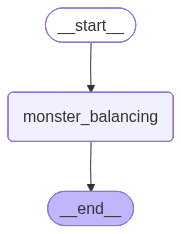

In [11]:
from graph import build_dungeon_graph
graph = build_dungeon_graph() 
graph